In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import anndata as ad 
import scanpy as sc
sys.path.append("../../spatial-clust-scripts-main/")
import utils
from sklearn.decomposition import PCA
import umap
import graph
#import visualize
import sklearn.metrics
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="anndata")

In [18]:
snap = pd.read_csv('../../data/spleen/double_snap_combo_stable_0327.csv', index_col=1).to_numpy()
stlearn = pd.read_csv('../../data/spleen/spleen_stlearn_pca30v2.csv', index_col=1).to_numpy()
sedr = pd.read_csv('../../data/spleen/spleen_sedr_32n.csv', index_col=1).to_numpy()
spagcn = np.load('../../data/spleen/conv_output_epoch_200.npy')
banksy = pd.read_csv('../../data/spleen/cellsnap_data_spleen_banksy_r1-all.csv').loc[:, 'PC1':'PC20'].to_numpy()
cellc = pd.read_csv('../../data/spleen/CC_spleen_30x4.csv').to_numpy()
meta = pd.read_csv('../../data/spleen/features_and_metadata.csv')

print([snap.shape,stlearn.shape, sedr.shape, spagcn.shape, banksy.shape, cellc.shape])

[(53500, 32), (53500, 30), (53500, 32), (53500, 30), (53500, 20), (53500, 120)]


In [19]:
import warnings
warnings.filterwarnings('ignore')
# for loop start:
batch = 5
dflist = []
for i in range(batch):
    print('at', i)
    
    indices = np.random.choice(stlearn.shape[0], 10000, replace=False)
    
    snap_sub = snap[indices]
    stlearn_sub = stlearn[indices]
    sedr_sub = sedr[indices]
    spagcn_sub = spagcn[indices]
    banksy_sub = banksy[indices]
    cellc_sub = cellc[indices]
    gglabel = meta.loc[indices,'cluster.termV2'].values
    
    ##### calculate umap
    
    # start to calculate silhoutte score
    snap_ss_list = []
    stlearn_ss_list = []
    sedr_ss_list = []
    spagcn_ss_list = []
    banksy_ss_list = []
    cellc_ss_list = []

    k_clusters = [x for x in range(5,30,2)]

    for k in k_clusters:

        ## snap
        snap_edges = graph.get_feature_edges(
            arr=snap_sub, pca_components=None,
            n_neighbors=15, metric='correlation', verbose=False
        )
        snap_labels = graph.graph_clustering(
            snap_sub.shape[0], snap_edges, resolution=None, n_clusters=k, n_runs=1,
            resolution_tol=0.05, seed=None, verbose=False
        )

        ## stlearn
        stlearn_edges = graph.get_feature_edges(
            arr=stlearn_sub, pca_components=None,
            n_neighbors=15, metric='correlation', verbose=False
        )
        stlearn_labels = graph.graph_clustering(
            stlearn_sub.shape[0], stlearn_edges, resolution=None, n_clusters=k, n_runs=1,
            resolution_tol=0.05, seed=None, verbose=False
        )

        ## sedr
        sedr_edges = graph.get_feature_edges(
            arr=sedr_sub, pca_components=None,
            n_neighbors=15, metric='correlation', verbose=False
        )
        sedr_labels = graph.graph_clustering(
            sedr_sub.shape[0], sedr_edges, resolution=None, n_clusters=k, n_runs=1,
            resolution_tol=0.05, seed=None, verbose=False
        )

        ## spagcn
        spagcn_edges = graph.get_feature_edges(
            arr=spagcn_sub, pca_components=None,
            n_neighbors=15, metric='correlation', verbose=False
        )
        spagcn_labels = graph.graph_clustering(
            spagcn_sub.shape[0], spagcn_edges, resolution=None, n_clusters=k, n_runs=1,
            resolution_tol=0.05, seed=None, verbose=False
        )

        ## banksy
        banksy_edges = graph.get_feature_edges(
            arr=banksy_sub, pca_components=None,
            n_neighbors=15, metric='correlation', verbose=False
        )
        banksy_labels = graph.graph_clustering(
            banksy_sub.shape[0], banksy_edges, resolution=None, n_clusters=k, n_runs=1,
            resolution_tol=0.05, seed=None, verbose=False
        )

        ## cellcharter
        cellc_edges = graph.get_feature_edges(
            arr=cellc_sub, pca_components=None,
            n_neighbors=15, metric='correlation', verbose=False
        )
        cellc_labels = graph.graph_clustering(
            cellc_sub.shape[0], cellc_edges, resolution=None, n_clusters=k, n_runs=1,
            resolution_tol=0.05, seed=None, verbose=False
        )
        
        snap_ss = sklearn.metrics.adjusted_rand_score(gglabel, snap_labels)
        stlearn_ss = sklearn.metrics.adjusted_rand_score(gglabel, stlearn_labels)
        sedr_ss = sklearn.metrics.adjusted_rand_score(gglabel, sedr_labels)
        spagcn_ss = sklearn.metrics.adjusted_rand_score(gglabel, spagcn_labels)
        banksy_ss = sklearn.metrics.adjusted_rand_score(gglabel, banksy_labels)
        cellc_ss = sklearn.metrics.adjusted_rand_score(gglabel, cellc_labels)

        snap_ss_list.append(snap_ss)
        stlearn_ss_list.append(stlearn_ss)
        sedr_ss_list.append(sedr_ss)
        spagcn_ss_list.append(spagcn_ss)
        banksy_ss_list.append(banksy_ss)
        cellc_ss_list.append(cellc_ss)
        
    data = {'k':k_clusters, 'ch_stlearn':stlearn_ss_list, 'ch_sedr':sedr_ss_list, 'ch_spagcn':spagcn_ss_list,
           'ch_banksy':banksy_ss_list, 'ch_cellc':cellc_ss_list, 'ch_snap':snap_ss_list}
    
    df = pd.DataFrame(data)
    df['batch'] = i
    dflist.append(df)
    
test = pd.concat(dflist)
test2 = test.melt(id_vars=['k'], value_vars=['ch_stlearn', 'ch_sedr', 'ch_spagcn', 'ch_banksy', 'ch_cellc', 'ch_snap'])
test2.to_csv('../../data/spleen/ARI_result_spleen_revloc.csv')

at 0
at 1
at 2
at 3
at 4


<Axes: xlabel='k', ylabel='value'>

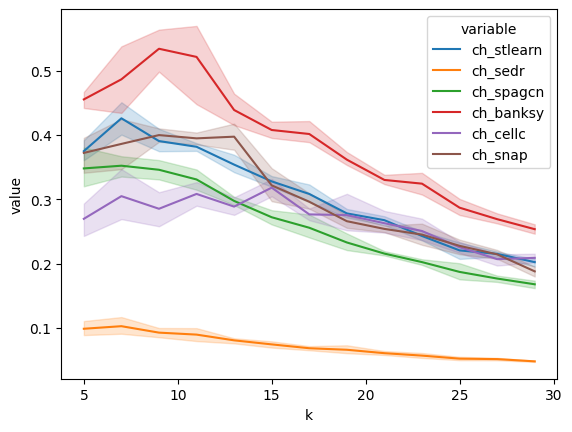

In [21]:
df = test2
sns.lineplot(data=df, x="k", y="value", hue="variable")

In [3]:
cca = pd.read_csv('../data/cca15_feat.csv').to_numpy()
mofa = pd.read_csv('../data/mofa_fc8.csv').to_numpy()
print([cca.shape, mofa.shape])

[(53500, 15), (53500, 8)]


In [4]:
# for loop start:
batch = 5
dflist = []
for i in range(batch):
    print('at', i)
    
    indices = np.random.choice(cca.shape[0], 10000, replace=False)
    
    cca_sub = cca[indices]
    mofa_sub = mofa[indices]
    
    ##### calculate umap
    
    # start to calculate silhoutte score
    cca_ss_list = []
    mofa_ss_list = []

    k_clusters = [x for x in range(5,30,2)]

    for k in k_clusters:

        ## cca
        cca_edges = graph.get_feature_edges(
            arr=cca_sub, pca_components=None,
            n_neighbors=15, metric='correlation', verbose=False
        )
        cca_labels = graph.graph_clustering(
            cca_sub.shape[0], cca_edges, resolution=None, n_clusters=k, n_runs=1,
            resolution_tol=0.05, seed=None, verbose=False
        )

        ## mofa
        mofa_edges = graph.get_feature_edges(
            arr=mofa_sub, pca_components=None,
            n_neighbors=15, metric='correlation', verbose=False
        )
        mofa_labels = graph.graph_clustering(
            mofa_sub.shape[0], mofa_edges, resolution=None, n_clusters=k, n_runs=1,
            resolution_tol=0.05, seed=None, verbose=False
        )
        
        cca_ss = sklearn.metrics.silhouette_score(cca_sub, cca_labels)
        mofa_ss = sklearn.metrics.silhouette_score(mofa_sub, mofa_labels)

        cca_ss_list.append(cca_ss)
        mofa_ss_list.append(mofa_ss)
        
    data = {'k':k_clusters, 'ch_cca':cca_ss_list,
            'ch_mofa':mofa_ss_list}
    
    df = pd.DataFrame(data)
    df['batch'] = i
    dflist.append(df)
    
test = pd.concat(dflist)
test2 = test.melt(id_vars=['k'], value_vars=['ch_cca', 'ch_mofa'])
test2.to_csv('../data/SS_result_spleen_ccamofa.csv')


at 0
at 1
at 2
at 3
at 4


In [2]:
# read in files
snap_embed = np.load("../data/double_snap_combo_stable_0327.npy")
df = pd.read_csv('../data/features_and_metadata.csv', index_col=0)
df = df.drop('nucl', axis = 1) # remove nuclear for vanilla clustering
features = df.iloc[:,3:-5].to_numpy()
concact_embed = np.load("../data/other_methods/concat_embedding.npy")
spice_embed = np.load("../data/other_methods/spicemix_embedding.npy")

##### load in muse 0-4 batch results
muse_embed0 = np.load("../data/other_methods/muse_final_spleen_rdm10k_0.npy")
muse_embed1 = np.load("../data/other_methods/muse_final_spleen_rdm10k_1.npy")
muse_embed2 = np.load("../data/other_methods/muse_final_spleen_rdm10k_2.npy")
muse_embed3 = np.load("../data/other_methods/muse_final_spleen_rdm10k_3.npy")
muse_embed4 = np.load("../data/other_methods/muse_final_spleen_rdm10k_4.npy")
muse_embedll = [muse_embed0, muse_embed1, muse_embed2, muse_embed3, muse_embed4]

print([snap_embed.shape, features.shape, concact_embed.shape,
      spice_embed.shape, muse_embed0.shape])

[(53500, 32), (53500, 30), (53500, 47), (53500, 20), (10000, 30)]


In [3]:
# for loop start:
batch = 5
dflist = []
for i in range(batch):
    print('at', i)
    
    indices = np.random.choice(snap_embed.shape[0], 10000, replace=False)
    
    snap_embed_sub = snap_embed[indices]
    features_sub = features[indices]
    concact_embed_sub = concact_embed[indices]
    spice_embed_sub = spice_embed[indices]
    muse_embed_sub = muse_embedll[i]
    
    ##### calculate umap
    
    # start to calculate silhoutte score
    feature_ss_list = []
    snap_ss_list = []
    concact_ss_list = []
    spice_ss_list = []
    muse_ss_list = []
    k_clusters = [x for x in range(5,30,2)]

    for k in k_clusters:

        ## feature
        feature_edges = graph.get_feature_edges(
            arr=features_sub, pca_components=None,
            n_neighbors=15, metric='correlation', verbose=False
        )
        feature_labels = graph.graph_clustering(
            features_sub.shape[0], feature_edges, resolution=None, n_clusters=k, n_runs=1,
            resolution_tol=0.05, seed=None, verbose=False
        )

        ## snap
        snap_edges = graph.get_feature_edges(
            arr=snap_embed_sub, pca_components=None,
            n_neighbors=15, metric='correlation', verbose=False
        )
        snap_labels = graph.graph_clustering(
            snap_embed_sub.shape[0], snap_edges, resolution=None, n_clusters=k, n_runs=1,
            resolution_tol=0.05, seed=None, verbose=False
        )

        ## concact 
        concact_edges = graph.get_feature_edges(
            arr=concact_embed_sub, pca_components=None,
            n_neighbors=15, metric='correlation', verbose=False
        )
        concact_labels = graph.graph_clustering(
            concact_embed_sub.shape[0], concact_edges, resolution=None, n_clusters=k, n_runs=1,
            resolution_tol=0.05, seed=None, verbose=False
        )
        
        ## muse 
        muse_edges = graph.get_feature_edges(
            arr=muse_embed_sub, pca_components=None,
            n_neighbors=15, metric='correlation', verbose=False
        )
        muse_labels = graph.graph_clustering(
            muse_embed_sub.shape[0], muse_edges, resolution=None, n_clusters=k, n_runs=1,
            resolution_tol=0.05, seed=None, verbose=False
        )
        
        ## spice 
        spice_edges = graph.get_feature_edges(
            arr=spice_embed_sub, pca_components=None,
            n_neighbors=15, metric='correlation', verbose=False
        )
        spice_labels = graph.graph_clustering(
            spice_embed_sub.shape[0], spice_edges, resolution=None, n_clusters=k, n_runs=1,
            resolution_tol=0.05, seed=None, verbose=False
        )

        feature_ss = sklearn.metrics.silhouette_score(features_sub, feature_labels)
        snap_ss = sklearn.metrics.silhouette_score(snap_embed_sub, snap_labels)
        concact_ss = sklearn.metrics.silhouette_score(concact_embed_sub, concact_labels)
        spice_ss = sklearn.metrics.silhouette_score(spice_embed_sub, spice_labels)
        muse_ss = sklearn.metrics.silhouette_score(muse_embed_sub, muse_labels)

        feature_ss_list.append(feature_ss)
        snap_ss_list.append(snap_ss)
        concact_ss_list.append(concact_ss)
        spice_ss_list.append(spice_ss)
        muse_ss_list.append(muse_ss)
        
    data = {'k':k_clusters, 'ch_feature':feature_ss_list,
            'ch_snap':snap_ss_list,'ch_concact':concact_ss_list,
           'ch_spice':spice_ss_list, 'ch_muse':muse_ss_list}
    
    df = pd.DataFrame(data)
    df['batch'] = i
    dflist.append(df)
    


at 0
at 1
at 2
at 3
at 4


In [4]:
test = pd.concat(dflist)
test2 = test.melt(id_vars=['k'], value_vars=['ch_feature', 'ch_snap', 'ch_concact', 'ch_spice', 'ch_muse'])
test2.to_csv('../data/SS_result_spleen_0327.csv')

#test = pd.concat(dflist)
#test2 = test.melt(id_vars=['k'], value_vars=['ch_feature', 'ch_snap', 'ch_concact', 'ch_spice', 'ch_muse'])
#figg = sns.lineplot(data=test2,x="k", y="value", hue="variable")

In [5]:
#figg.get_figure().savefig('../plots/SS_allmethods_dbGNNstab.svg', dpi = 300) 